In [70]:
%reload_ext autoreload

In [71]:
%autoreload 2
%matplotlib inline

from collections import Counter, defaultdict 
import editdistance
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Make analysis graphs for consistency/independence/robustness

In [72]:
def get_top_sequence_per_batch(data):
    top_per_batch=[]
    for i in data.batch.unique():
        sub_data=data[data.batch==i] #must also group by model type and landscape id
        #print (sub_data.true_score.max())
        top_per_batch.append(sub_data.true_score.max())
    return (top_per_batch)

def compute_cumulative_outcomes(data): 
    outcomes=pd.DataFrame(columns=["landscape_id","start_id","model_type","explorer_type",
                                   "batch","max_fitness","cum_max_fitness"])
    for landscape in data.landscape_id.unique():
        if landscape==str(-1): #or start_id==str(-1):
            continue
        print(landscape)
        valid_start_ids=[x for x in data.start_id.unique()]# if landscape[landscape.index("L"): landscape.index("R")] in x]
        for start_id in valid_start_ids:
            for explorer_type in data.explorer_type.unique():
                sub_data = data[(data.landscape_id==landscape)&\
                               (data.start_id==start_id)&\
                               (data.explorer_type==explorer_type)] 
                cum_fit=0
                for batch, max_fitness in enumerate(get_top_sequence_per_batch(sub_data)):
                    if max_fitness>cum_fit:
                       cum_fit = max_fitness 
                    outcomes = outcomes.append(pd.DataFrame.from_records([{"landscape_id":landscape,\
                                          "start_id":start_id,\
                                          "explorer_type": explorer_type,\
                                          "batch": batch+1, \
                                          "max_fitness": max_fitness,\
                                          "cum_max_fitness": cum_fit}])) 
                    
    return outcomes

SIX6_REF_R1


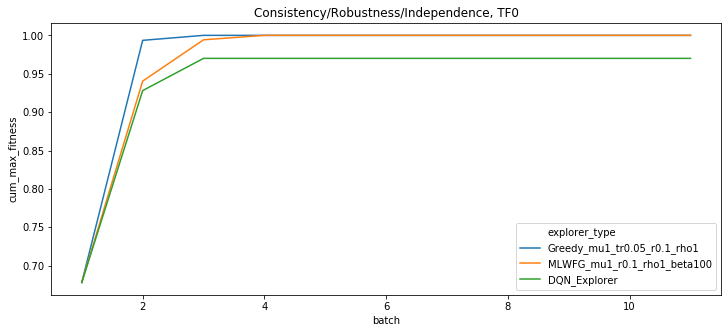

In [73]:
data1=pd.read_csv("../simulations/evaluations_test_six6/consistency_robustness_independence/Greedy_mu1_tr0.05_r0.1_rho1.csv",index_col=False)
data2=pd.read_csv("../simulations/evaluations_test_six6/consistency_robustness_independence/MLWFG_mu1_r0.1_rho1_beta100.csv",index_col=False)
data3 = pd.read_csv("../simulations/eval/consistency_robustness_independence/DQN_Explorer.csv")
data3 = data3[(data3['landscape_id'] == 'SIX6_REF_R1')]
data = data1.append(data2).append(data3)
sub_data=data[(data.model_type=="NAMb_ss0.9") & (data.start_id == 'TF0')]
outcomes = compute_cumulative_outcomes(sub_data)
plt.figure(figsize=(12,5))
plt.title('Consistency/Robustness/Independence, TF0')
sns.lineplot(x="batch",y="cum_max_fitness",hue="explorer_type",data= outcomes, color="r")

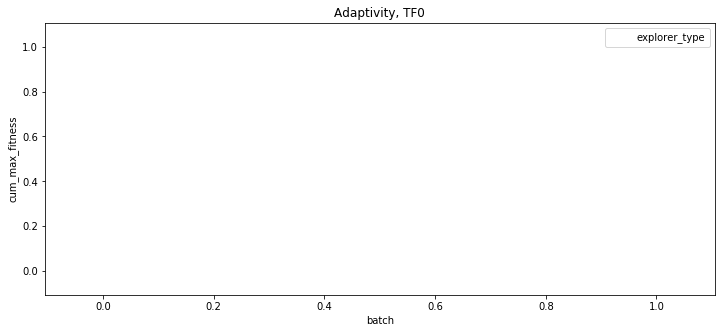

In [74]:
data1=pd.read_csv("../simulations/eval/adaptivity/CMAES.csv", index_col=False)
data2=pd.read_csv("../simulations/eval/adaptivity/DQN_Explorer.csv", index_col=False)
data3 = pd.read_csv("../simulations/eval/adaptivity/DynaPPO_Agent_0.5_5_10.csv", index_col=False)
data4 = pd.read_csv("../simulations/eval/adaptivity/PPO_Agent.csv", index_col=False)
data = data1.append(data2).append(data3).append(data4)
sub_data=data[(data.model_type=="NAMb_ss0.9") & (data.start_id == 'TF0') & (data['landscape_id'] == 'SIX6_REF_R1')]
outcomes = compute_cumulative_outcomes(sub_data)
plt.figure(figsize=(12,5))
plt.title('Adaptivity, TF0')
sns.lineplot(x="batch",y="cum_max_fitness",hue="explorer_type",data= outcomes, color="r")

SIX6_REF_R1


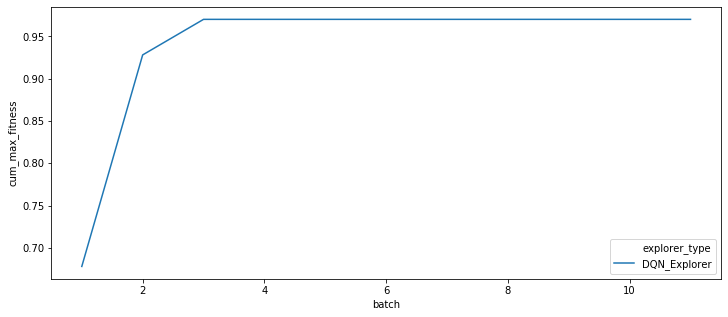

In [75]:
data3 = pd.read_csv("../simulations/eval/consistency_robustness_independence/DQN_Explorer.csv")
data3 = data3[(data3['start_id'] == 'TF0') & (data3['landscape_id'] == 'SIX6_REF_R1') & 
              (data3['model_type'] == 'NAMb_ss0.9')]
outcomes3 = compute_cumulative_outcomes(data3)
plt.figure(figsize=(12,5))
sns.lineplot(x="batch",y="cum_max_fitness",hue="explorer_type",data=outcomes3, color="r")

## Run analysis graphs for other simulation types 

In [76]:
def compute_sequential_edit_distances(seq_df, seq=None):
    # seq_df is a dataframe with the same format as that of the output logs 
    seqs_fitnesses = seq_df[['sequence', 'true_score']]
    seqs_fitnesses.sort_values('true_score', ascending=False, inplace=True)
    seqs = seqs_fitnesses['sequence'].values
    distances = []
    for i in range(len(seqs) - 1):
        comp_seq = seqs[i+1]
        top_seqs = seqs[:(i+1)]
        distances.append([editdistance.eval(seq, comp_seq) for seq in top_seqs])
    return distances 

def compute_all_edit_distances(seq_df, seq=None):
    seqs = seq_df['sequence'].values
    distances = []
    for seq in seqs:
        distances.append([editdistance.eval(seq, seq2) for seq2 in seqs])
    return distances

def edit_distance_from_top(seq_df, top_seq):
    seqs = seq_df['sequence'].values
    distances = []
    for seq in seqs:
        distances.append(editdistance.eval(seq, top_seq))
    return distances    

In [77]:
top_seqs = {
    'B1L14RNA1': '',
    'B2L14RNA1+2': '',
    'TF': ''
}

def plot_diversity(func, landscape_id, start_id, title, cutoff=0):
    file_names = {'DynaPPO': 'DynaPPO_Agent_0.5_10_20.csv', 
                  'Greedy': 'Greedy_mu1_tr0.05_r0.2_rho1.csv',
                  'CMAES': 'CMAES.csv',
                  'BO': 'BO_Explorer_RNA_All.csv',
                  'CbAS': 'CbAS_consistency_robustness_independence_04-09-2020.csv'
                  }
    if landscape_id == 'B1L14RNA1':
        peaks = open('../plotting_data_subset/peaks_B1L14RNA1.txt')
    elif landscape_id == 'B1L14RNA2':
        peaks = open('../plotting_data_subset/peaks_B2L14RNA1+2.txt')
    batches = {}
    for name, file_name in file_names.items():
        test_data = pd.read_csv("../plotting_data_subset/" + file_name)
        batch = test_data[(test_data['batch'] == 9) 
                              & (test_data['landscape_id'] == 'B1L14RNA1') 
                              & (test_data['start_id'] == 'startRNAL14_0') 
                              & (test_data['model_type'].str.contains('ENS_3_NAMb_ss1'))
                              & (test_data['true_score'] >= cutoff)]
        batches[name] = batch 
    plt.figure(figsize=(15, 10))
    plt.title(title)
    max_count = 0
    counts_by_exp = defaultdict(dict)
    for name, batch in batches.items():
        sequential_distances = func(batch, top_seqs[landscape_id])
        counts = Counter(itertools.chain.from_iterable(sequential_distances))
        total = sum(counts.values())
        if counts:
            max_count = max(max_count, max(counts.keys()))
        for key, val in sorted(counts.items()):
            counts_by_exp[key][name] = val / total 
    # plot data 
    x, y, widths = defaultdict(list), defaultdict(list), defaultdict(list)
    for key in counts_by_exp:
        num_explorers = len(counts_by_exp[key])
        midpoint = (num_explorers - 1) / 2
        width = 1/(2*num_explorers)
        for ind, (name, val) in enumerate(counts_by_exp[key].items()):
            x[name].append(key + (ind - midpoint)*width)
            y[name].append(val)
            widths[name].append(width)
    for name in x:
        plt.bar(x[name], y[name], width=widths[name], label=name)
    plt.xticks(range(max_count + 1))
    plt.xlabel('Edit Distance')
    plt.ylabel('Fraction')
    plt.legend()
    plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


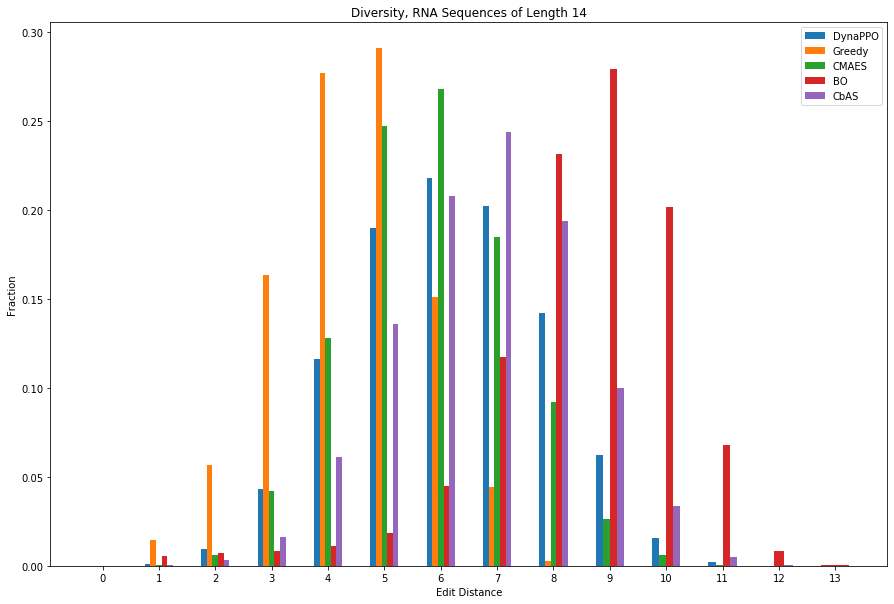

In [78]:
plot_diversity(compute_sequential_edit_distances, 'B1L14RNA1', 'startRNAL14_0', 
               'Diversity, RNA Sequences of Length 14')

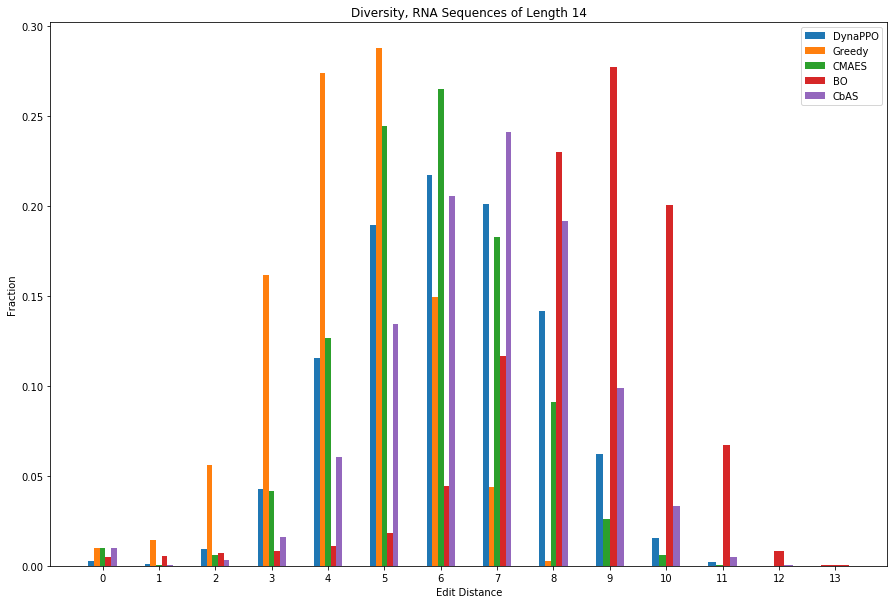

In [79]:
plot_diversity(compute_all_edit_distances, 'B1L14RNA1', 'startRNAL14_0', 
               'Diversity, RNA Sequences of Length 14')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


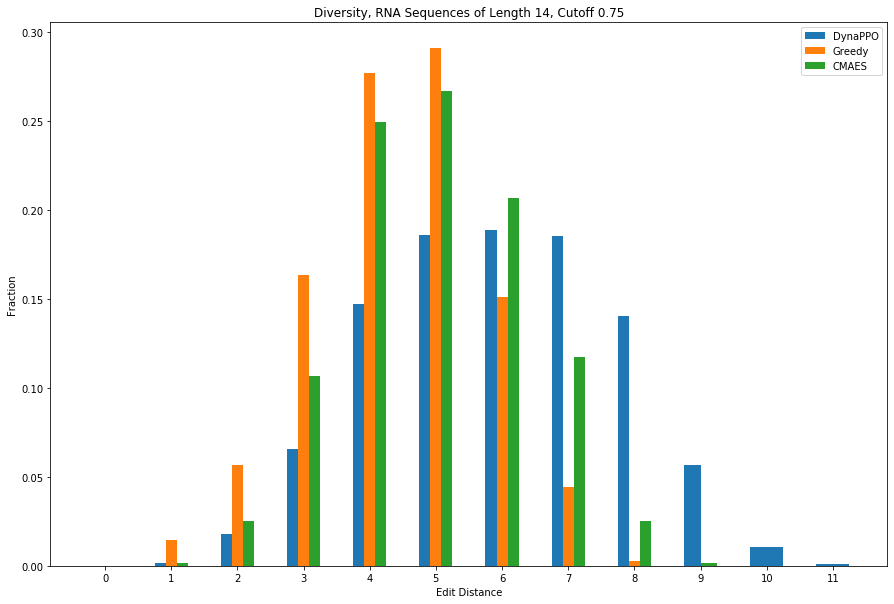

In [80]:
plot_diversity(compute_sequential_edit_distances, 'B1L14RNA1', 'startRNAL14_0', 
               'Diversity, RNA Sequences of Length 14, Cutoff 0.75', cutoff=0.75)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


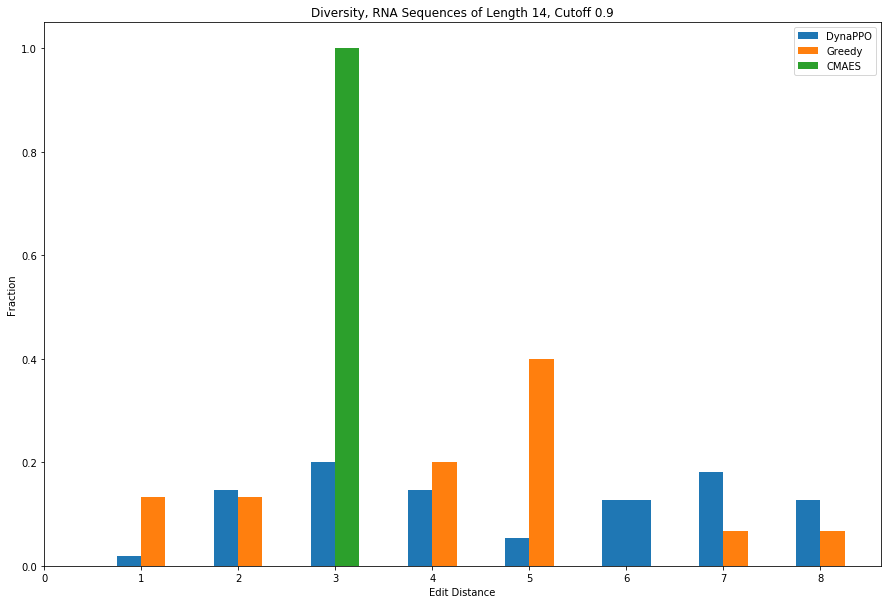

In [81]:
plot_diversity(compute_sequential_edit_distances, 'B1L14RNA1', 'startRNAL14_0', 
               'Diversity, RNA Sequences of Length 14, Cutoff 0.9', cutoff=0.9)